# Анализ рекламных источников в игре

## Оглавление
<a id = "index"></a>

1. [Задание](#task)
1. [Описание данных](#data_description)
1. [Настройка окружения](#env)
1. [Загрузка данных](#first_look)
1. [Подготовка данных](#etl)
1. [Исследовательский анализ данных](#eda)
1. [Проверка гипотез](#main_hypotheses)
1. [Выводы и рекомендации](#conclusion)
1. [Ссылка на презентацию](#presentation)

## Задание
<a id = "task"></a>
[В оглавление](#index)

__Вводная информация.__   
Компания развивает мобильную игру «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики. 

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

Завершение первого уровня требует от игрока выполнения одного из двух условий:
- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

__Задачи:__
- Провести исследовательский анализ данных.
- Проанализировать влияние источника перехода в игру на поведение пользователя.
- Проверить статистические гипотезы:
    1. Время завершения уровня различается в зависимости способа прохождения:
        - через реализацию проекта,
        - через победу над первым игроком.
    2. Количество построек различается в зависимости способа прохождения:
        - через реализацию проекта,
        - через победу над первым игроком.

## Описание данных
<a id = "data_description"></a>
[В оглавление](#index)

__Основной датасет__   
В основном датасете содержатся данные по игре первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.   
Пользователи находятся на первом уровне.


- `events.csv`:
    - `event_datetime` — время события;
    - `event` — одно из трёх событий:
        1. `building` — объект построен,
        2. `finished_stage_1` — первый уровень завершён,
        3. `project` — проект завершён;
    - `building_type` — один из трёх типов здания:
        1. `assembly_shop` — сборочный цех,
        2. `spaceport` — космопорт,
        3. `research_center` — исследовательский центр;
    - `user_id` — идентификатор пользователя;
    - `project_type` — тип реализованного проекта;

__Дополнительные датасеты__
- `ad_cost.csv`:
    - `day` - день, в который был совершен клик по объявлению;
    - `source` - источник трафика;
    - `cost` - стоимость кликов.
- `user_source.csv`:
    - `user_id` - идентификатор пользователя,
    - `source` - источников, с которого пришёл пользователь, установивший приложение.

## Настройка окружения
<a id = "env"></a>
[В оглавление](#index)

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

# отображение одного знака после запятой
pd.options.display.float_format = '{:,.1f}'.format
plt.rcParams["figure.dpi"] = 150

## Загрузка данных
<a id = "first_look"></a>
[В оглавление](#index)

In [2]:
events = pd.read_csv('events.csv')
events.head()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


In [3]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


По таблице необходимо:
- перевести данные столбца с датой в корректный тип,
- проверить причины появления пропусков и их заполнение.

___

In [4]:
ad_costs = pd.read_csv('ad_costs.csv')
ad_costs.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.9
1,facebook_ads,2020-05-04,548.4
2,facebook_ads,2020-05-05,260.2
3,facebook_ads,2020-05-06,178.0
4,facebook_ads,2020-05-07,111.8


In [5]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


Требуется перевод типа данных в столбце с датой.

___

In [6]:
user_source = pd.read_csv('user_source.csv')
user_source.head()

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


In [7]:
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


Дополнительных действий по таблице не требуется.

## Подготовка данных
<a id = "etl"></a>
[В оглавление](#index)

#### Перевод столбцов даты в корректный тип

In [8]:
events['event_datetime'] = pd.to_datetime(events['event_datetime'])
events['date'] = events['event_datetime'].astype('datetime64[D]')
events['week'] = events['event_datetime'].dt.week
events['weekday'] = events['event_datetime'].dt.dayofweek
events['hour'] = events['event_datetime'].dt.hour

ad_costs['day'] = ad_costs['day'].astype('datetime64[D]')

/Users/maksim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


#### Переименование столбцов

In [9]:
ad_costs.rename(
    columns={"day": "date"},
    errors="raise",
    inplace=True
)

#### Проверка пропущенных значений

In [10]:
events['building_type'].isna().sum()

7683

In [11]:
events[events['building_type'].isna()]['event'].value_counts()

finished_stage_1    5817
project             1866
Name: event, dtype: int64

In [12]:
events['event'].value_counts()

building            127957
finished_stage_1      5817
project               1866
Name: event, dtype: int64

Пропуски в столбце `building_type` появляются, если пользователь завершил уровень.   
__Заполенение не требуется.__ 

In [13]:
events['project_type'].value_counts()

satellite_orbital_assembly    1866
Name: project_type, dtype: int64

Пропуски в столбце `project_type` появляются, так как пользователи только начали игру и не реализовали других игровых проектов.
__Заполенение не требуется.__

#### Словарь рекламных источников

In [14]:
ad_source_dict = {
    "facebook_ads": "Facebook",
    "instagram_new_adverts": "Instagram",
    "yandex_direct": "Yandex",
    "youtube_channel_reklama": "Youtube",
    
}

In [15]:
users = user_source.merge(
    events.groupby(['user_id', 'event'])['event_datetime'].count().unstack(level=1).reset_index(),
    on="user_id"
).merge(
    events.groupby(['user_id', 'building_type'])['event_datetime'].count().unstack(level=1).reset_index(),
    on="user_id"
)
users

,user_id,source,building,finished_stage_1,project,assembly_shop,research_center,spaceport
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,13.0,nan,nan,6.0,1.0,6.0
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,9.0,nan,nan,4.0,nan,5.0
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,4.0,nan,nan,2.0,nan,2.0
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,8.0,1.0,nan,4.0,nan,4.0
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,12.0,nan,nan,3.0,1.0,8.0
...,...,...,...,...,...,...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,instagram_new_adverts,9.0,1.0,nan,7.0,1.0,1.0
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,facebook_ads,16.0,nan,nan,5.0,3.0,8.0
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct,9.0,1.0,nan,4.0,2.0,3.0
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts,7.0,nan,nan,6.0,nan,1.0


#### Определение условия завершения уровня 1 по каждому игроку

In [16]:
def type_of_completion_stage_1(event, project_type):
    if event == "project":
        return "built_project"
    elif event == "finished_stage_1" and  project_type != "satellite_orbital_assembly":
        return "won_first_enemy"
    else:
        return "in_process"

In [17]:
events['type_of_completion'] = (events.apply(
        lambda x: type_of_completion_stage_1(x.event, x.project_type), axis=1
))

#### Присвоение каждому событию дня активности, индивидуального для каждого пользователя

In [18]:
# свод даты первого события по игрокам
user_first_event_date = events.groupby('user_id')['event_datetime'].first().reset_index()
user_first_event_date.columns = ['user_id', 'first_event_datetime']
user_first_event_date['first_event_date'] = user_first_event_date['first_event_datetime'].astype('datetime64[D]')
user_first_event_date.head()

,user_id,first_event_datetime,first_event_date
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-06
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,2020-05-06
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,2020-05-05
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-05
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,2020-05-05


In [19]:
# добавление даты первого события для каждого игрока 
events = events.merge(
    user_first_event_date[['user_id', 'first_event_date']],
    #how='left',
    on='user_id'
)

In [20]:
# расчет для каждого события дня активности, индивидуального для каждого пользователя
events['day_of_activity'] = (events['date'] - events['first_event_date']).dt.days

In [21]:
events = events.merge(
    user_source,
    how="left",
    on="user_id"
)

#### Формирование когорт

In [22]:
# расчет количества построек и игроков по когортам
pre_cohorts_1 = events.pivot_table(
    values=[
        'building_type', 
        'user_id', 
    ], 
    index=['first_event_date', 'date'],  
    aggfunc={
        'building_type': 'count',
        'user_id': 'nunique',
    })
pre_cohorts_1.head()

building_type  user_id
first_event_date date                              
2020-05-04       2020-05-04           8170     5860
                 2020-05-05           4332     3021
                 2020-05-06           4709     3204
                 2020-05-07           5075     3412
                 2020-05-08           5640     3564

In [23]:
# свод статуса игроков по когортам
pre_cohorts_2 = events.groupby(['first_event_date','date', 'type_of_completion']).agg({
    'user_id':'nunique',
}).unstack(level=2)
pre_cohorts_2.columns = pre_cohorts_2.columns.droplevel(0)
pre_cohorts_2.fillna(0, inplace=True)
pre_cohorts_2 = pre_cohorts_2.astype(int)
pre_cohorts_2.head()

type_of_completion           built_project  in_process  won_first_enemy
first_event_date date                                                  
2020-05-04       2020-05-04              0        5860                1
                 2020-05-05              0        3020                3
                 2020-05-06              0        3203                3
                 2020-05-07              0        3411                4
                 2020-05-08              1        3557               15

In [24]:
cohorts = pre_cohorts_1.merge(pre_cohorts_2, left_index=True, right_index=True)
cohorts.reset_index(inplace=True)
cohorts['day_of_activity'] = (cohorts['date'] - cohorts['first_event_date']).dt.days
cohorts.head()

,first_event_date,date,building_type,user_id,built_project,in_process,won_first_enemy,day_of_activity
0,2020-05-04,2020-05-04,8170,5860,0,5860,1,0
1,2020-05-04,2020-05-05,4332,3021,0,3020,3,1
2,2020-05-04,2020-05-06,4709,3204,0,3203,3,2
3,2020-05-04,2020-05-07,5075,3412,0,3411,4,3
4,2020-05-04,2020-05-08,5640,3564,1,3557,15,4


#### Расчет маркетинговых показателей

In [25]:
# общие затраты на маркетинг
ad_costs_sum = ad_costs.groupby('source')['cost'].sum().to_frame()
ad_costs_sum

# источники трафика игроков 
ad_efficiency = user_source.groupby('source')['user_id'].count().to_frame()
ad_efficiency

# свод датафрейма с затратами на привлечение пользователей
ad_result = ad_costs_sum.merge(
    ad_efficiency,
    left_index=True,
    right_index=True
)
ad_result.columns = ['cost', 'users']
ad_result.reset_index(inplace=True)

# cтоимость привлечения одного пользователя
ad_result['cost_per_user'] = ad_result['cost'] / ad_result['users']
ad_result = ad_result.sort_values('cost_per_user',ascending=False)
ad_result

,source,cost,users,cost_per_user
0,facebook_ads,"2,140.9",2726,0.8
1,instagram_new_adverts,"2,161.4",3347,0.6
2,yandex_direct,"2,233.1",4817,0.5
3,youtube_channel_reklama,"1,068.1",2686,0.4


## Исследовательский анализ данных
<a id = "eda"></a>
[В оглавление](#index)

### Маркетинговые затраты

In [26]:
print("Маркетинговая кампания проводилась с {:%d.%m.%Y} по {:%d.%m.%Y}.".format(
    ad_costs.date.min(), ad_costs.date.max()     ))

Маркетинговая кампания проводилась с 03.05.2020 по 09.05.2020.



Период маркетинговой кампании выбран не совсем оптимально. Кампания наложилась на майские праздники, когда люди обычно на отдыхе и проводят меньше времени в сети. 

In [27]:
print("Суммарные затраты на маркетинговую кампанию: {:.0f} у.е.".format(ad_costs.cost.sum()))

Суммарные затраты на маркетинговую кампанию: 7604 у.е.


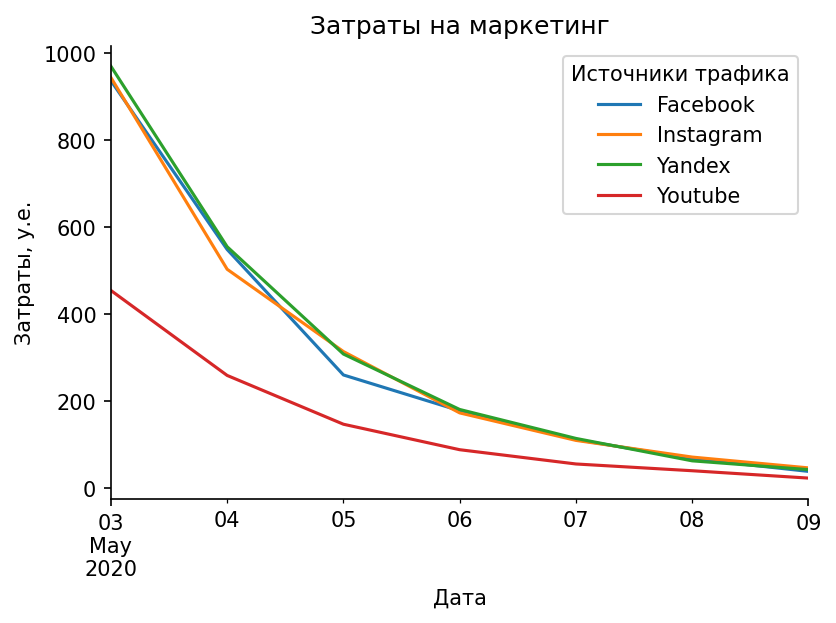

In [28]:
# затраты на маркетинг по времени
ad_costs_trend = ad_costs.pivot_table(
    index='date',
    columns='source',
    values='cost',
    aggfunc='sum',
)

# график
ad_costs_trend.plot()
plt.title('Затраты на маркетинг')
plt.ylabel('Затраты, у.е.')
plt.xlabel('Дата')
plt.legend(
    [ad_source_dict[x] for x in ad_costs_trend.columns],
    title='Источники трафика',
    loc='upper right'
)
sns.despine()
#plt.grid(axis='x')
plt.show()

#### Затраты на привлечение пользователей

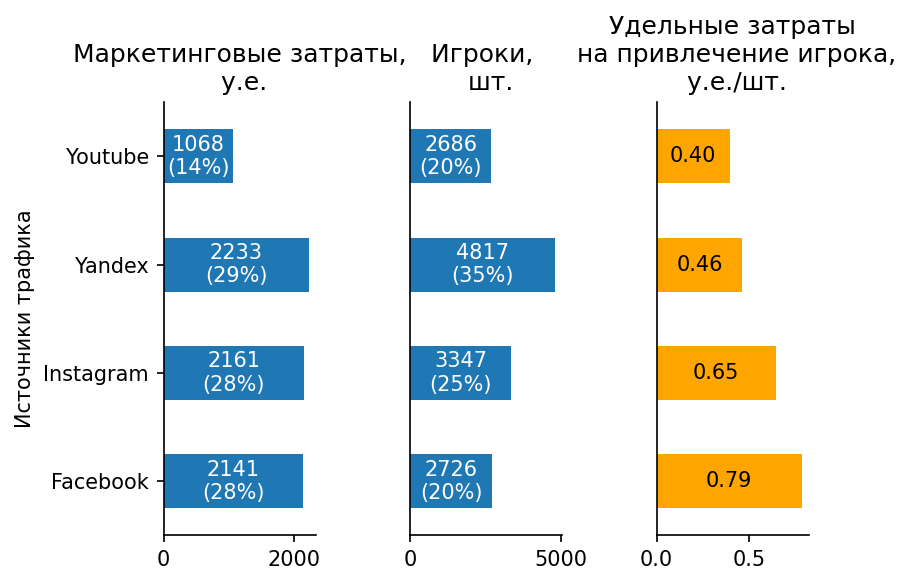

In [29]:
# график распределения открытия сессий
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

g1 = ad_result.cost.plot.barh(ax=ax1)
g2 = ad_result.users.plot.barh(ax=ax2)
g3 = ad_result.cost_per_user.plot.barh(ax=ax3, color='orange',)
ax1.set_title('Маркетинговые затраты,\n у.е.')#, weight='bold')
ax2.set_title('Игроки, \n шт.')#, weight='bold')
ax3.set_title('Удельные затраты\n на привлечение игрока,\n у.е./шт.')#, weight='bold')


ax1.set(
#    title='', 
    ylabel='Источники трафика',
    xlabel=''
)

ax1.set_yticklabels([ad_source_dict[x] for x in ad_result.source])
ax2.set_yticks([])
ax3.set_yticks([])

for i, value in enumerate(ad_result.iterrows()):
    ax1.text(
            value[1]['cost']/2, i,
            '{:.0f}\n({:.0%})'.format(value[1]['cost'] , value[1]['cost']/ad_result['cost'].sum()),
            ha='center', va='center', color='white'

        )
    ax2.text(
            value[1]['users']/2, i,
        '{:.0f}\n({:.0%})'.format(value[1]['users'] , value[1]['users']/ad_result['users'].sum()),
            ha='center', va='center', color='white'

        )
    
    ax3.text(
            value[1]['cost_per_user']/2, i,
            '{:.2f}'.format(value[1]['cost_per_user']),
            ha='center', va='center', color='black'

        )

sns.despine()
plt.grid(False)
plt.tight_layout()
plt.show()

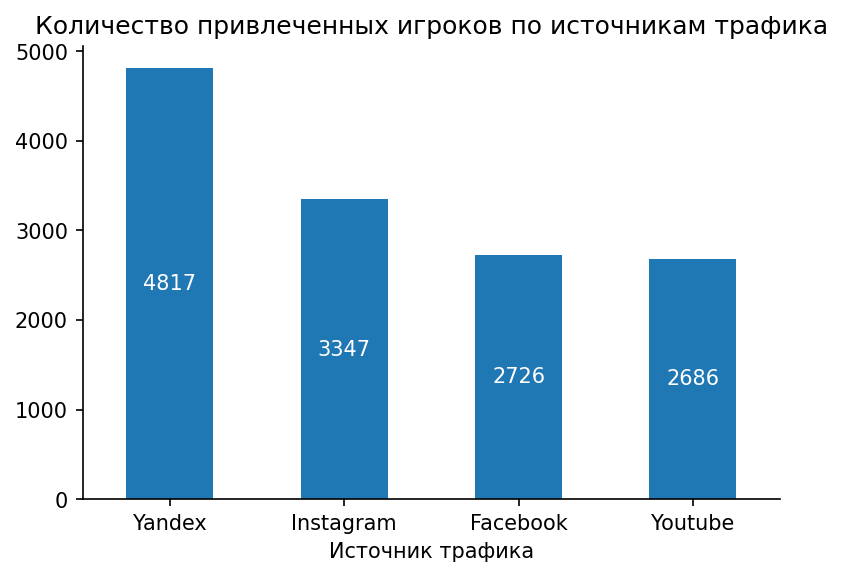

In [30]:
# график
ax = ad_efficiency.sort_values('user_id', ascending=False).plot.bar(y='user_id', legend=False)
plt.title('Количество привлеченных игроков по источникам трафика')
plt.ylabel('')
plt.xlabel('Источник трафика')
plt.gca().set_xticklabels(
    [ad_source_dict[x] for x in ad_efficiency.sort_values('user_id', ascending=False).index],
    rotation=0
)

for i, value in enumerate(ad_efficiency.sort_values('user_id', ascending=False).iterrows()):
    ax.text(
        i, value[1]['user_id']/2,
        '{:.0f}'.format(value[1]['user_id']),
        ha='center', va='center', color='white'
    )
sns.despine()
plt.show()

- Примерно равные доли бюджета 28-29% направлены на Yandex, Instagram и Facebook.
- От Yandex пришла наибольшая доля игроков — 35% или 4,8 тыс. На втором месте Instagram с 3,3 тыс. На третьем месте Facebook и Youtube по 2,7 тыс.
- Вероятно, что маркетинговая кампания была нацелена на игроков из СНГ, из-за большого прихода игроков от российской системы Yandex.
- Наименьшие удельные затраты на привлечение игроков у Youtube — 0,4 у.е. Это вдвое меньше наиболее дорогого показателя у Facebook — 0,79 у.е.

### Количество игроков

#### Количество пользователей после установки игры

In [31]:
print("Количество пользователей, установивших игру: {} шт.".format(user_source.user_id.nunique()))
print("Количество пользователей, проявивших любую активность: {} шт.".format(events.user_id.nunique()))

Количество пользователей, установивших игру: 13576 шт.
Количество пользователей, проявивших любую активность: 13576 шт.


Все игроки, установившие игру, совершили хотя бы одно действие.  
Если это не особенность выгрузки, то это хороший показатель.

#### DAU, WAU

In [32]:
dau_mean = int(events.groupby('date').agg({'user_id': 'nunique'}).mean())
wau_mean = int(events.groupby('week').agg({'user_id': 'nunique'}).mean())

print('Среднее количество уникальных пользователей за исследуемый период:\n \
      в день: {}\n \
      в неделю: {}'.format(dau_mean, wau_mean))

Среднее количество уникальных пользователей за исследуемый период:
       в день: 2884
       в неделю: 6120


<Figure size 2400x750 with 0 Axes>

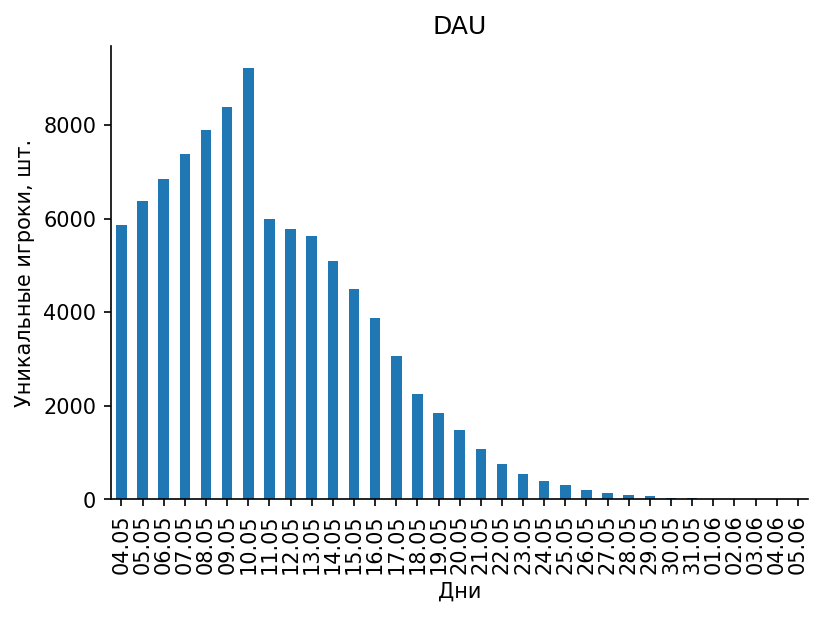

In [33]:
# датафрейм
events_dau = events.groupby('date').agg({'user_id': 'nunique'})

# график
plt.figure(figsize = (16,5))
events_dau.plot.bar(legend=False)
plt.gca().set_xticklabels(events_dau.index.strftime('%d.%m'), rotation=90)
plt.title('DAU')
plt.ylabel('Уникальные игроки, шт.')
plt.xlabel('Дни')
#plt.grid(axis='y')
sns.despine()
plt.show()

- Первые 7 дней рост уникальных игроков обеспечивает маркетинговая кампания. 
- Пиковое значение количества уникальных пользователей — около 10 тыс. в последний день маркетинговой кампании.

<Figure size 2400x750 with 0 Axes>

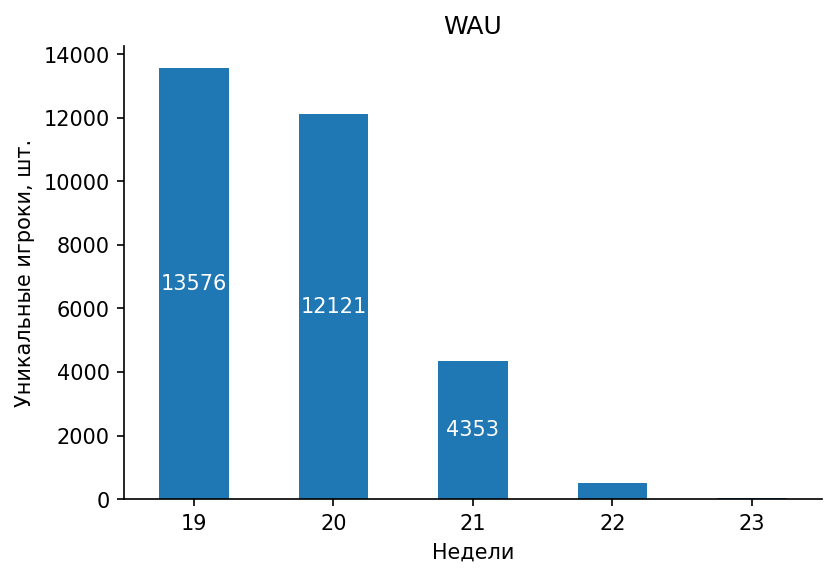

In [34]:
# датафрейм
events_wau = events.groupby('week').agg({'user_id': 'nunique'})

# график
plt.figure(figsize = (16,5))
events_wau.plot.bar(rot=0, legend=False)
plt.title('WAU')
plt.ylabel('Уникальные игроки, шт.')
plt.xlabel('Недели')
#plt.grid(axis='y')

for i, value in enumerate(events_wau.iterrows()):
    if value[1]['user_id'] < 1000:
        pass
    else:
        plt.gca().text(
            i, value[1]['user_id']/2,
            '{:.0f}'.format(value[1]['user_id']),
            ha='center', va='center', color='white'
        )
    
sns.despine()
plt.show()

- В первую неделю маркетинговой кампании количество уникальных игроков близко к 14 тыс.
- На третью неделю количество игроков снижается более, чем втрое.

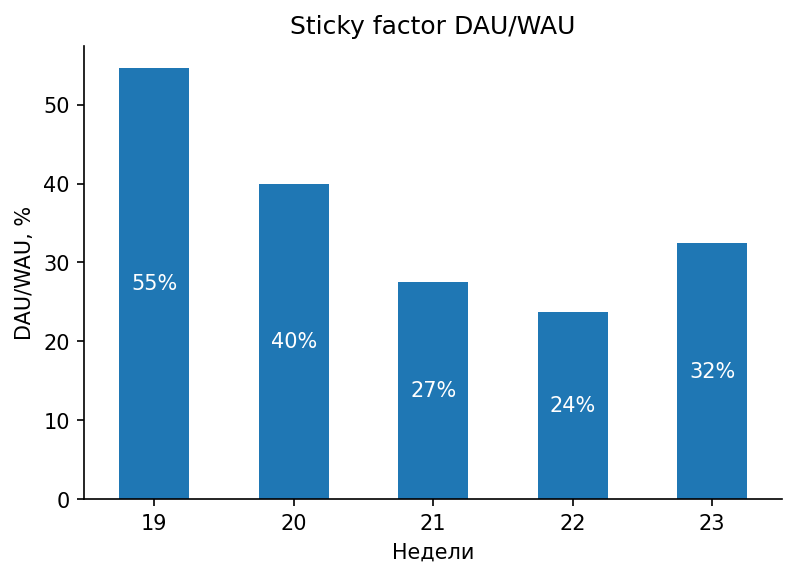

In [35]:
# датафрейм
sticky_wau_trend = ((events.groupby(['week', 'date']).agg({'user_id': 'nunique'}).reset_index()).groupby(
        ['week']).agg({'user_id': 'mean'}) / events_wau) * 100
sticky_wau_trend.plot.bar(legend=False, rot=0)

# график
plt.title('Sticky factor DAU/WAU')
plt.xlabel('Недели')
plt.ylabel('DAU/WAU, %')

for i, value in enumerate(sticky_wau_trend.iterrows()):
    plt.gca().text(
        i, value[1]['user_id']/2,
        '{:.0f}%'.format(value[1]['user_id']),
        ha='center', va='center', color='white'
    )

sns.despine()
plt.show()

- Показатель Sticky factor DAU/WAU в первую неделю превышает 50%.
- На четвертую неделю снижается до 25%
- Рост DAU/WAU в последнюю неделю обусловлен тем, что малые абсолютные значения оказывают большое влияние.

#### Количество уникальных игроков

- Затраты на маркетинг различаются по дням проведения кампании, поэтому состав когорт нельзя сравнивать по абсолютным показателям.
- Необходимо сравнивать по отношению к количеству игроков в первый день когорты.

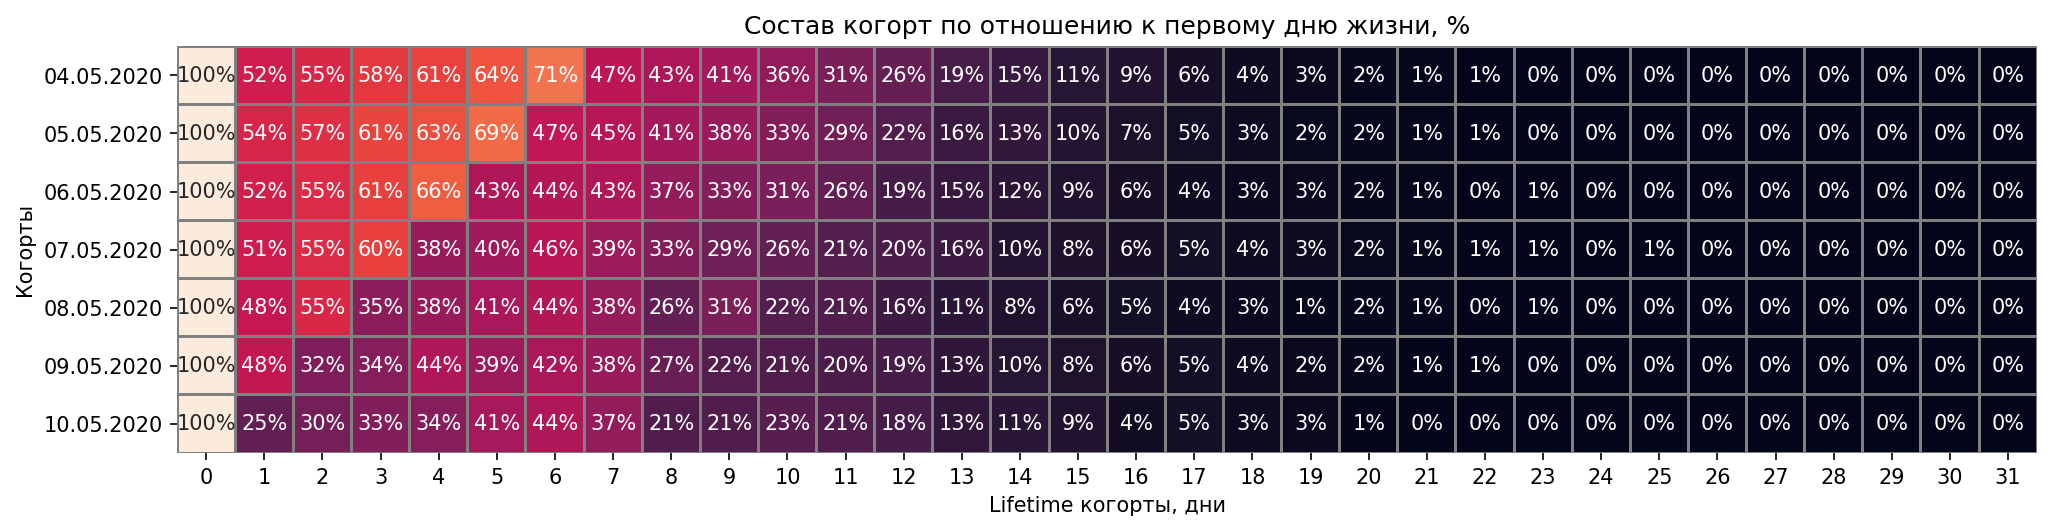

In [36]:
# Количество уникальных игроков
users_by_cohorts = cohorts.pivot_table(
    index='first_event_date',
    columns='day_of_activity',
    values='user_id',
).fillna(0).astype(int)

# отнесение к первому дню когорты
users_by_cohorts_perc = users_by_cohorts.div(users_by_cohorts[0], axis=0)

# график
plt.figure(figsize = (16,5))

sns.heatmap(
    users_by_cohorts_perc,
    annot=True, 
    fmt='.0%', 
    linewidths=1,
    linecolor='gray',
    yticklabels=users_by_cohorts.index.strftime('%d.%m.%Y'), 
    robust=True,
    square=True,
    cbar=0
)
plt.yticks(rotation=0) 
plt.title('Состав когорт по отношению к первому дню жизни, %')
plt.xlabel('Lifetime когорты, дни')
plt.ylabel('Когорты')
plt.show()

- В первые 7 дней жизни когорты количество уникальных игроков растет:
    - Вероятно, что отчасти это связано, с проведением маркетинговой кампании.
    - Для когорты последнего дня маркетинговой кампании рост возврата в игру уникальных игроков составил почти 20пп.
- После 12 дня в когортах активны не более 20% первоначального количества игроков.

### Влияние источника перехода в игру на поведение пользователя

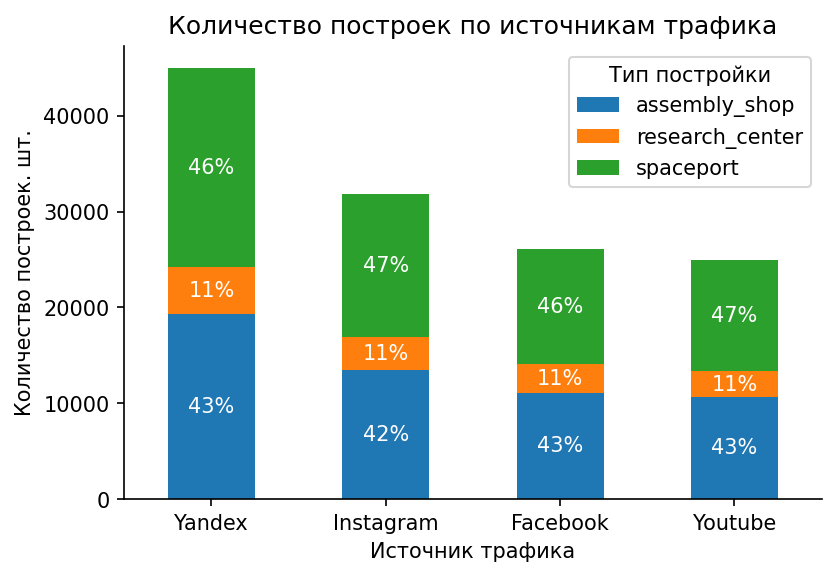

In [37]:
buildings = events.pivot_table(
    index='source',
    columns='building_type',
    values='event_datetime',
    aggfunc='count',
)
buildings['total'] = buildings.sum(axis=1)
buildings = buildings.sort_values('total', ascending=False)


buildings[['assembly_shop','research_center', 'spaceport'] ].plot.bar(stacked=True, rot=0)
plt.gca().set_xticklabels([ad_source_dict[x] for x in buildings.index])

for i, value in enumerate(buildings[['assembly_shop','research_center', 'spaceport'] ].iterrows()):
    plt.gca().text(
        i, value[1]['assembly_shop']/2,
        '{:.0%}'.format(value[1]['assembly_shop'] / buildings.loc[value[0]]['total']),
        ha='center', va='center', color='white'
    )
    plt.gca().text(
        i, value[1]['assembly_shop'] + value[1]['research_center']/2,
        '{:.0%}'.format(value[1]['research_center'] / buildings.loc[value[0]]['total']),
        ha='center', va='center', color='white'
    )
    plt.gca().text(
        i, value[1]['assembly_shop'] + value[1]['research_center']+ value[1]['spaceport']/2,
        '{:.0%}'.format(value[1]['spaceport'] / buildings.loc[value[0]]['total']),
        ha='center', va='center', color='white'
    )

plt.title('Количество построек по источникам трафика')
plt.xlabel('Источник трафика')
plt.ylabel('Количество построек. шт.')

plt.legend(title='Тип постройки')
sns.despine()
plt.show()

In [38]:
# Статус игроков на уровне 1
user_status_stage_1 = events.user_id.drop_duplicates().to_frame().merge(
    events.query('type_of_completion != "in_process"')[['user_id', 'type_of_completion']],
    how="left",
    on="user_id"
)
user_status_stage_1.type_of_completion.fillna("in_process", inplace=True)
user_status_stage_1

,user_id,type_of_completion
0,55e92310-cb8e-4754-b622-597e124b03de,in_process
1,c07b1c10-f477-44dc-81dc-ec82254b1347,built_project
2,c07b1c10-f477-44dc-81dc-ec82254b1347,won_first_enemy
3,6edd42cc-e753-4ff6-a947-2107cd560710,won_first_enemy
4,92c69003-d60a-444a-827f-8cc51bf6bf4c,in_process
...,...,...
15437,20bc9d79-10c4-4f2d-862e-4a6dece3b4ec,won_first_enemy
15438,daea0325-f7c5-4008-b5f6-f89fc2c1e019,in_process
15439,7b225969-375a-455e-a14a-ed1ab373fb65,in_process
15440,cafd1b8b-507b-49ae-abf0-89fe863a8b03,in_process


In [39]:
user_status_stage_1 = user_status_stage_1.type_of_completion.value_counts().to_frame().sort_values('type_of_completion', ascending=False)

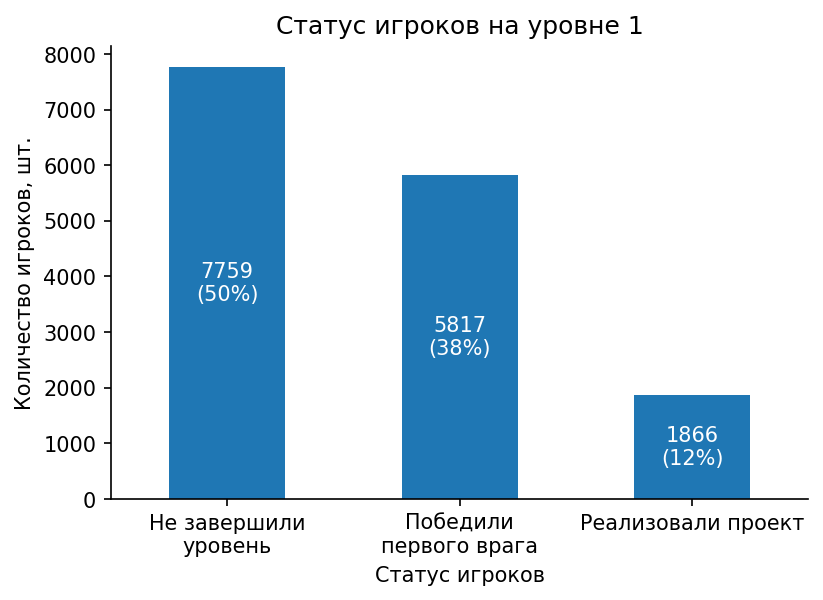

In [40]:
# график
user_status_stage_1.plot.bar(rot=0, legend=False)
plt.title('Статус игроков на уровне 1')
plt.xlabel('Статус игроков')
plt.ylabel('Количество игроков, шт.')
for i, value in enumerate(user_status_stage_1.head().iterrows()):
    plt.gca().text(
        i, value[1]['type_of_completion']/2,
        '{:.0f}\n({:.0%})'.format(
            value[1]['type_of_completion'],
            value[1]['type_of_completion'] / user_status_stage_1.type_of_completion.sum()),
        ha='center', va='center', color='white'
    )
plt.gca().set_xticklabels(
    ["Не завершили\nуровень", "Победили\nпервого врага", "Реализовали проект"],
    rotation=0
)
sns.despine()
plt.show()

- Половина игроков завершили уровень 1.
- 38% сделали через победу над врагом.

#### Количество построек

In [41]:
users.fillna(0)

,user_id,source,building,finished_stage_1,project,assembly_shop,research_center,spaceport
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,13.0,0.0,0.0,6.0,1.0,6.0
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,9.0,0.0,0.0,4.0,0.0,5.0
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,4.0,0.0,0.0,2.0,0.0,2.0
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,8.0,1.0,0.0,4.0,0.0,4.0
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,12.0,0.0,0.0,3.0,1.0,8.0
...,...,...,...,...,...,...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,instagram_new_adverts,9.0,1.0,0.0,7.0,1.0,1.0
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,facebook_ads,16.0,0.0,0.0,5.0,3.0,8.0
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct,9.0,1.0,0.0,4.0,2.0,3.0
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts,7.0,0.0,0.0,6.0,0.0,1.0


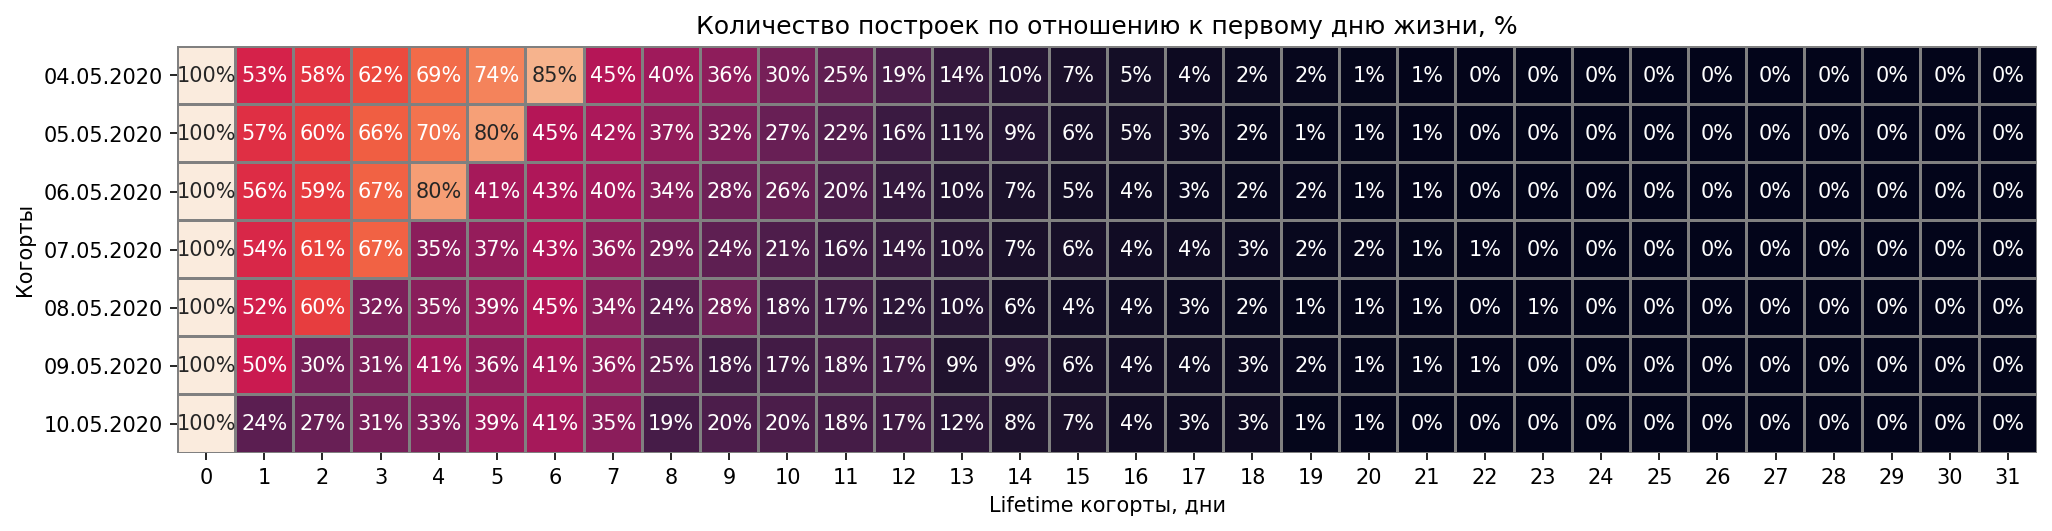

In [42]:
# Количество построек
building_by_cohorts = cohorts.pivot_table(
    index='first_event_date',
    columns='day_of_activity',
    values='building_type',
).fillna(0).astype(int)

# отнесение к первому дню когорты
building_by_cohorts_perc = building_by_cohorts.div(building_by_cohorts[0], axis=0)

# график
plt.figure(figsize = (16,5))

sns.heatmap(
    building_by_cohorts_perc,
    annot=True, 
    fmt='.0%', 
    linewidths=1,
    linecolor='gray',
    yticklabels=building_by_cohorts.index.strftime('%d.%m.%Y'), 
    robust=True,
    square=True,
    cbar=0
)
plt.yticks(rotation=0) 
plt.title('Количество построек по отношению к первому дню жизни, %')
plt.xlabel('Lifetime когорты, дни')
plt.ylabel('Когорты')
plt.show()

In [43]:
user_source.merge(
    events.query('type_of_completion != "in_process"')[['user_id', 'type_of_completion']],
    on="user_id",
    how="left"

)

,user_id,source,type_of_completion
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,NaN
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,NaN
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,NaN
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,won_first_enemy
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,NaN
...,...,...,...
15437,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,facebook_ads,NaN
15438,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct,won_first_enemy
15439,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts,NaN
15440,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,facebook_ads,built_project


#### Распределение построенных объектов

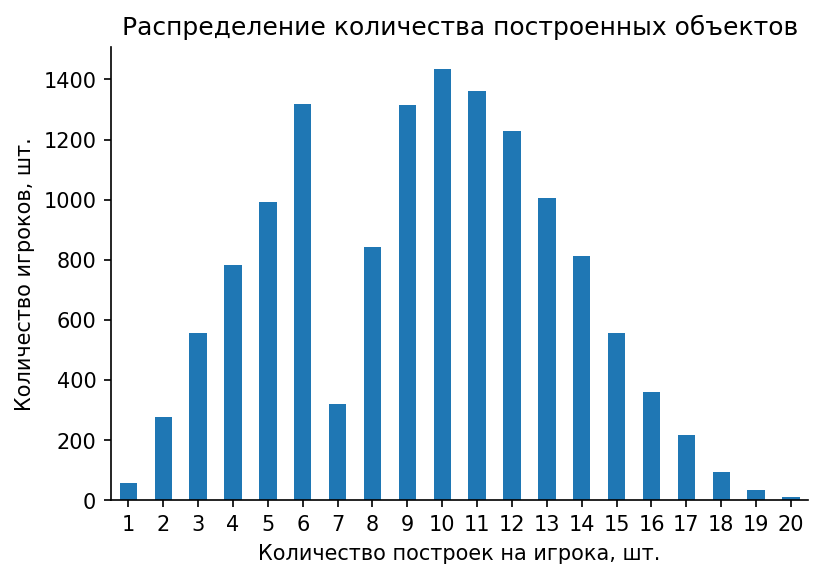

In [44]:
events.groupby('user_id')['building_type'].count().value_counts().sort_index().plot.bar(rot=0)
sns.despine()
plt.title('Распределение количества построенных объектов')
plt.xlabel('Количество построек на игрока, шт.')
plt.ylabel('Количество игроков, шт.')
plt.show()

- Вероятно, что пользователи, которые не завершили уровень 1, ушли из игры после 6 постройки.
- Необходимо провести глубинное исследование поведения игроков на этом этапе и ввести мотивирующие действия в игре для предотвращения ухода.


#### Время на завершение уровня 1

In [45]:
# свод игроков, построивших проект
users_built_project = events.query('type_of_completion != "in_process" and \
project_type == "satellite_orbital_assembly"')[['user_id', 'type_of_completion','day_of_activity']].copy()

# свод игроков, победивших врага
users_won_first_enemy = events.query('type_of_completion == "won_first_enemy"').groupby(
    ['user_id','type_of_completion','day_of_activity'])['date'].last().reset_index().copy()
users_won_first_enemy.drop(columns=['date'], inplace=True)

# сводный датафрейм
time_to_finish_stage_1 = pd.concat(
    [users_built_project, users_won_first_enemy],
    ignore_index=True).reset_index(drop=True)

time_to_finish_stage_1.head()

,user_id,type_of_completion,day_of_activity
0,c07b1c10-f477-44dc-81dc-ec82254b1347,built_project,9
1,65a92713-5969-48b1-8945-bfefa5063887,built_project,14
2,fa352362-d258-472c-b295-2796ccc39fa3,built_project,14
3,7b3b6554-7949-4065-9808-d6c79bdc2f58,built_project,10
4,b374304d-2f74-4cc1-a4e2-500da44a06c7,built_project,10


In [46]:
for feature in time_to_finish_stage_1.type_of_completion.unique():
    print("Время на завершение уровня 1 по условию:", feature)
    display(time_to_finish_stage_1.query('type_of_completion == @feature').describe())
    print()

Время на завершение уровня 1 по условию: built_project


,day_of_activity
count,"1,866.0"
mean,11.8
std,3.7
min,4.0
25%,9.0
50%,11.0
75%,14.0
max,29.0



Время на завершение уровня 1 по условию: won_first_enemy


,day_of_activity
count,"5,817.0"
mean,11.8
std,4.1
min,0.0
25%,9.0
50%,12.0
75%,14.0
max,31.0


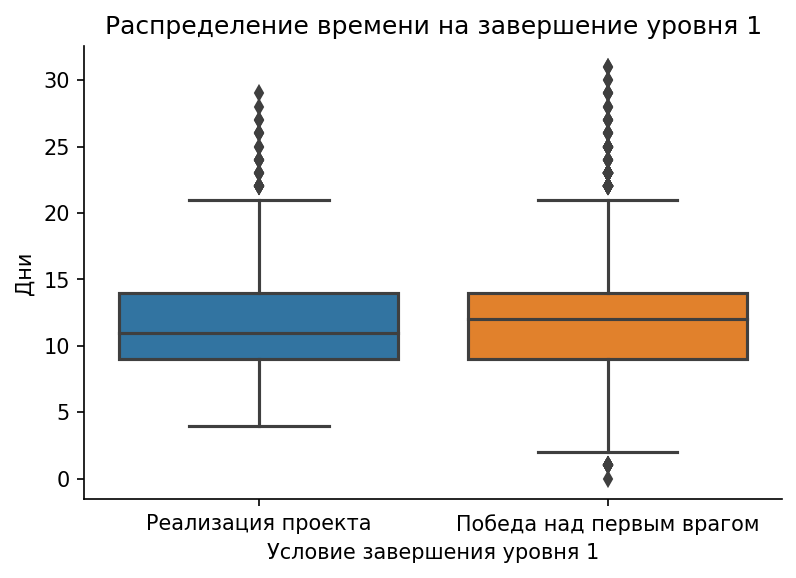

In [47]:
# график распределения время на завершение уровня 1
g = sns.boxplot(
    y='day_of_activity',
    x="type_of_completion", 
    data=time_to_finish_stage_1,
)

plt.title('Распределение времени на завершение уровня 1')
plt.ylabel('Дни')
plt.xlabel('Условие завершения уровня 1')
plt.gca().set_xticklabels(['Реализация проекта', 'Победа над первым врагом'])
sns.despine()
plt.show()

- __В целом, баланс времени на завершение уровня 1 выдержан:__
    - В среднем, игроки завершают уровень за 11,8 дней независимо от условия завершения.
    - По медиане через постройку проекта уровень 1 завершается за 11 дней, а через первую победу за 12 дней.
- __Целесообразно провести дополнительное исследование алгоритма балансировки и подбора противников.__
    - Стандартное отклонение времени на завершение уровня 1 по условию победы больше, чем через постройку проекта. 
    - Вероятно, слабым игрокам попадаются слишком сильные противники и наоборот. 
- В следующем разделе проекта будет проверена статистическая гипотеза: время завершения уровня различается в зависимости способа прохождения.

#### Распределение количества построек в зависимости от условия завершения уровня 1

In [48]:
# свод игроков, завершивших уровень 1
user_finished_stage_1 = events.query('type_of_completion != "in_process"')[['user_id', 'type_of_completion']]
user_finished_stage_1.set_index('user_id', inplace=True)

# определение количества построек по игрокам
building_cnt = events.pivot_table(
    index='user_id',
    columns='building_type',
    values='date',
    aggfunc='count',
)
building_cnt['total'] = building_cnt.sum(axis=1)

# распределение количества построек в зависимости от условия завершения уровня 1
user_building_activity = user_finished_stage_1.merge(
    building_cnt,
    how="left",
    left_index=True,
    right_index=True
)
user_building_activity.head()

,type_of_completion,assembly_shop,research_center,spaceport,total
user_id,,,,,
001d39dc-366c-4021-9604-6a3b9ff01e25,won_first_enemy,4.0,nan,4.0,8.0
003ee7e8-6356-4286-a715-62f22a18d2a1,won_first_enemy,4.0,1.0,3.0,8.0
004074f8-251a-4776-922c-8348dca1a2f6,won_first_enemy,6.0,2.0,4.0,12.0
00464e5e-28ed-4be6-bf44-517ef7b3937b,won_first_enemy,4.0,nan,4.0,8.0
0056c007-c082-43cc-bdef-afc49bca4cb9,won_first_enemy,1.0,nan,2.0,3.0


In [49]:
for feature in user_building_activity.type_of_completion.unique():
    print("Количество построек до завершения уровня 1 по условию:", feature)
    display(user_building_activity.query('type_of_completion == @feature').describe())
    print()

Количество построек до завершения уровня 1 по условию: won_first_enemy


,assembly_shop,research_center,spaceport,total
count,"5,817.0","4,208.0","5,760.0","5,817.0"
mean,4.4,1.8,4.8,10.4
std,1.9,0.9,2.3,3.2
min,1.0,1.0,1.0,2.0
25%,3.0,1.0,3.0,9.0
50%,5.0,2.0,5.0,11.0
75%,6.0,2.0,7.0,12.0
max,7.0,5.0,10.0,20.0



Количество построек до завершения уровня 1 по условию: built_project


,assembly_shop,research_center,spaceport,total
count,"1,866.0","1,866.0","1,866.0","1,866.0"
mean,4.9,2.0,5.8,12.6
std,1.8,1.0,2.2,2.2
min,1.0,1.0,1.0,10.0
25%,4.0,1.0,4.0,11.0
50%,5.0,2.0,6.0,12.0
75%,6.0,3.0,7.0,14.0
max,7.0,5.0,10.0,20.0


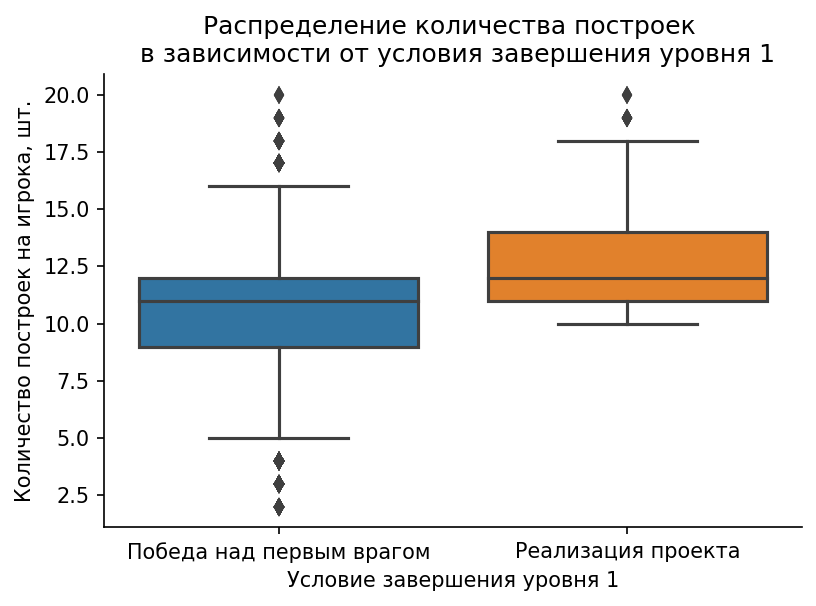

In [50]:
g = sns.boxplot(
    y='total',
    x="type_of_completion", 
    data=user_building_activity,
)
plt.title('Распределение количества построек \n в зависимости от условия завершения уровня 1')
plt.ylabel('Количество построек на игрока, шт.')
plt.xlabel('Условие завершения уровня 1')
sns.despine()
#plt.grid(axis='y')
plt.gca().set_xticklabels(['Победа над первым врагом', 'Реализация проекта'])
plt.show()

- Медианные значения количества построек до завершения уровня 1 через победу 11 шт. близко к 12 постройкам для победы через реализацию проекта.
- При этом, игрокам нужно от 10 построек что бы завершить уровень через постройку, а для победы над врагом от 5.
- __Вероятно, что баланс построек на завершение уровня 1 не выдержан. Игроки смогут обойти систему прокачки и покупки зданий через победу над врагом.__
- __Необходимо сбалансировать игровую систему до введения монетизации.__
- В следующем разделе проекта будет проверена статистическая гипотеза: количество построек различается в зависимости способа прохождения.

## Проверка гипотез
<a id = "main_hypotheses"></a>
[В оглавление](#index)

Для дальнейшей проверки принимаем уровень статистической значимости 0.05, так как это локальное маркетинговое исследование.

In [51]:
# критический уровень статистической значимости
alpha = .05 

### Время завершения уровня различается в зависимости способа прохождения

Различие времени завершения уровня в зависимости способа прохождения через __реализацию проекта__ или через __победу над первым игроком__ должно быть проверено через гипотезу о равенстве средних двух генеральных совокупностей:
- нулевая гипотеза: время завершения уровня не зависит от способа прохождения (среднее время через __реализацию проекта__ равно среднему времени через __победу над первым игроком__).
- альтернативная гипотеза: время завершения уровня зависит от способа прохождения.

In [52]:
# время завершения уровня через реализацию проекта
time_built_project = time_to_finish_stage_1.query('type_of_completion == "built_project"')['day_of_activity']
# время завершения уровня через победу над первым игроком
time_won_first_enemy = time_to_finish_stage_1.query('type_of_completion == "won_first_enemy"')['day_of_activity']

In [53]:
results = st.ttest_ind(
    time_built_project, 
    time_won_first_enemy)

print("Среднее время до завершения уровня 1:")
print("  - Победа над врагом, дни: {:.1f}.".format(time_won_first_enemy.mean()))
print("  - Реализация проекта, дни: {:.1f}.".format(time_built_project.mean()))
print()

print('p-значение: {:.3f}'.format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу. Время завершения уровня зависит от способа прохождения.")
else:
    print("Не получилось отвергнуть нулевую гипотезу. \nВремя завершения уровня 1 не зависит от способа прохождения.")

Среднее время до завершения уровня 1:
  - Победа над врагом, дни: 11.8.
  - Реализация проекта, дни: 11.8.

p-значение: 0.846
Не получилось отвергнуть нулевую гипотезу. 
Время завершения уровня 1 не зависит от способа прохождения.


__Время завершения уровня не зависит от способа прохождения.__

___

### Количество построек различается в зависимости способа прохождения

Различие количества построек в зависимости способа прохождения через __реализацию проекта__ или через __победу над первым игроком__ должно быть проверено через гипотезу о равенстве средних двух генеральных совокупностей:
- нулевая гипотеза: количество построек не зависит от способа прохождения (среднее время через __реализацию проекта__ равно среднему времени через __победу над первым игроком__).
- альтернативная гипотеза: количество построек зависит от способа прохождения уровня.

In [54]:
# время завершения уровня через реализацию проекта
buildings_built_project = user_building_activity.query('type_of_completion == "built_project"')['total']
# время завершения уровня через победу над первым игроком
buildings_won_first_enemy = user_building_activity.query('type_of_completion == "won_first_enemy"')['total']

In [55]:
results = st.ttest_ind(
    buildings_built_project, 
    buildings_won_first_enemy)

print("Среднее количество построек до завершения уровня 1:")
print("  - Победа над врагом: {:.0f} шт.".format(buildings_won_first_enemy.mean()))
print("  - Реализация проекта: {:.0f} шт.".format(buildings_built_project.mean()))
print()
print('p-значение: {:.3f}'.format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу. \nКоличество построек до завершения уровня 1 зависит от способа прохождения.")
else:
    print("Не получилось отвергнуть нулевую гипотезу. Количество построек до завершения уровня 1 не зависит от способа прохождения.")

Среднее количество построек до завершения уровня 1:
  - Победа над врагом: 10 шт.
  - Реализация проекта: 13 шт.

p-значение: 0.000
Отвергаем нулевую гипотезу. 
Количество построек до завершения уровня 1 зависит от способа прохождения.


__Количество построек зависит от способа прохождения уровня.__

## Выводы и рекомендации
<a id = "conclusion"></a>
[В оглавление](#index)

- Маркетинговая кампания проводилась с 03.05.2020 по 09.05.2020.  
__Период маркетинговой кампании выбран не совсем оптимально. Кампания наложилась на майские праздники, когда люди обычно на отдыхе и проводят меньше времени в сети.__
___

- От Yandex пришла наибольшая доля игроков — 35% или 4,8 тыс. На втором месте Instagram с 3,3 тыс. На третьем месте Facebook и Youtube по 2,7 тыс.
- Вероятно, что маркетинговая кампания была нацелена на игроков из СНГ, из-за большого прихода игроков от российской системы Yandex.
- Наименьшие удельные затраты на привлечение игроков у Youtube — 0,4 у.е. Это вдвое меньше наиболее дорогого показателя у Facebook — 0,79 у.е.  
__Необходимо скорректировать маркетинговую стратегию продвижения и увеличить затраты на привлечение через Youtube.__
___

- Среднее количество уникальных пользователей за исследуемый период:
    - в день: 2884
    - в неделю: 6120
- После 12 дня в когортах активны не более 20% первоначального количества игроков.
- Половина игроков завершили уровень 1:
    - 38% сделали через победу над врагом.
    - 12% через строительство проекта.

- Вероятно, что пользователи, которые не завершили уровень 1, ушли из игры после 6 постройки.  
__Необходимо провести глубинное исследование поведения игроков на этом этапе и ввести мотивирующие действия в игре для предотвращения ухода.__
___
- Среднее время до завершения уровня 1:
  - Победа над врагом, дни: 12.
  - Реализация проекта, дни: 12.
- Подтвержденная статистическая гипотеза: время завершения уровня 1 не зависит от способа прохождения.  
- Стандартное отклонение времени на завершение уровня 1 по условию победы больше, чем через постройку проекта. Вероятно, слабым игрокам попадаются слишком сильные противники и наоборот.  
__Целесообразно провести дополнительное исследование алгоритма балансировки и подбора противников.__
___

- Среднее количество построек до завершения уровня 1:
  - Победа над врагом: 10 шт.
  - Реализация проекта: 13 шт.
- Подтвержденная статистическая гипотеза: количество построек зависит от способа прохождения уровня.
- Вероятно, что баланс построек на завершение уровня 1 не выдержан. Игроки смогут обойти систему прокачки и покупки зданий через победу над врагом.  
__Необходимо сбалансировать игровую систему до введения монетизации.__

    

## Ссылка на презентацию
<a id = "presentation"></a>
[В оглавление](#index)

https://yadi.sk/d/5SF22-m2C-aWgA